In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

# Config

In [6]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/pseud_ashcolor_4label"
    train_label_path = f"{dataset_path}/labels/model3_iter_0/"
    new_label_path = f"{dataset_path}/labels/model3_iter_1/"
    train_model_path = ["/kaggle/working/notebook/experiment/v1.1/model23/model23/model23.pth",
                        "/kaggle/working/notebook/experiment/v1.1/model23/model23/model23.pth",
                        "/kaggle/working/notebook/experiment/v1.1/model23/model23/model23.pth",]
    exp_name = os.getcwd().split('/')[-1]
    exp_description = "model2_iter1"

    # ============== model cfg =============
    model_arch = 'UnetPlusPlus'
    backbone = 'efficientnet-b7'
    in_chans = 3
    target_size = 4
    fold = 3

    # ============== training cfg =============
    train_batch_size = 24
    valid_batch_size = train_batch_size

    epochs = 50
    if debug:
        epochs = 20

    lr = 1e-4
    loss = "DiceLoss"
    smooth = 300

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5, rotate_limit=(10, 10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 300

# Dataset

In [7]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")
valid_df = valid_df.dropna()

train_df_true_label = train_df[~train_df["label_path"].isnull()]
train_df_pseud_label = train_df[train_df["label_path"].isnull()]

fill_path = CFG.train_label_path + train_df["record_id"].astype("str") + "_"+train_df["time"].astype("str")+".npy"
train_df_pseud_label["label_path"] = fill_path

train_df_true_label.loc[:, "fold"] = -1

kf = KFold(n_splits=CFG.fold, random_state=42, shuffle=True)
train_df_pseud_label.loc[:, "fold"] = None
for i, fold in enumerate(kf.split(train_df_pseud_label)):
    train_df_pseud_label["fold"].iloc[fold[1]] = i

train_df = pd.concat([train_df_pseud_label, train_df_true_label], axis=0).sort_values(by=["record_id", "time"]).reset_index(drop=True)

if CFG.debug:
    train_df=train_df[:200]
    valid_df=valid_df[:200]
train_df.shape, valid_df.shape
train_df.head(10)

,record_id,image_path,time,label_path,fold
0,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_0.npy,0
1,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_1.npy,2
2,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_2.npy,2,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_2.npy,2
3,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_3.npy,3,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_3.npy,0
4,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_4.npy,4,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/true/195731008142151_4.npy,-1
5,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_5.npy,5,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_5.npy,2
6,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_6.npy,6,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_6.npy,0
7,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_7.npy,7,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/195731008142151_7.npy,2
8,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/1108741208571075_0.npy,2
9,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model3_iter_0/1108741208571075_1.npy,1



len(dataset_train) = 164232
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([4, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



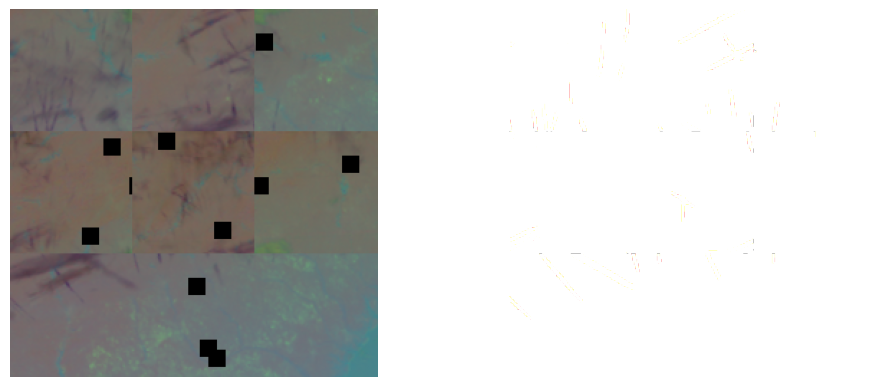

In [8]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list, "pseudo_train")
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list, "pseudo_train")

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(10, dataset_train)

# Training

In [10]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

for fold in range(CFG.fold):
    print(f"fold : {fold}\n")
    dataset_train = ContrailsDataset(train_df[train_df["fold"] != fold], CFG.train_aug_list, "pseudo_train")
    dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)

    model, dice_score, thresh = load_model(CFG.train_model_path[fold])
    print(f"model_dice_score:  {dice_score:.4f}")
    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))
    model = nn.DataParallel(model, device_ids=device_ids)

    scaler = amp.GradScaler()
    criterion = smp.losses.DiceLoss(mode="multilabel", smooth=CFG.smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs, eta_min=1e-7)
    thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

    dice_score = 0
    slacknotify=SlackNotify(f"{CFG.exp_description} fold: {fold}")
    for epoch in range(CFG.epochs):
        model.train()

        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
        loss_train, loss_val = 0.0, 0.0
        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                loss_train += loss.detach().item()

            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                  f"Loss: {loss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()

        cum_pred = []
        cum_true = []
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)[:, 2]
                loss_val += criterion(preds, masks).item()
                preds = torch.sigmoid(preds)
                cum_pred.append(preds.cpu().detach().numpy())
                cum_true.append(masks.cpu().detach().numpy())

            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))

        cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
        cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))

        dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)

        if dice_score_ > dice_score:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}\tBEST")
            epoch_best = epoch
            dice_score = dice_score_
            torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                        "model_arch": CFG.model_arch, "backbone": CFG.backbone, "in_chans": CFG.in_chans, "target_size": CFG.target_size,},
                       f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth')
        else:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}")

    slacknotify.send_reply(f" {CFG.exp_description} training finished\tbest score : {dice_score}", True)

fold : 0

model_arch:  UnetPlusPlus
backbone:  efficientnet-b7
model_dice_score:  0.6644


Epoch 0/50  Mem : 14.9GB  LR : 1.00E-04  Loss: 0.2674: 100%|██████████| 4848/4848 [24:45<00:00,  3.26it/s]
Val Loss: 0.0210: 100%|██████████| 78/78 [00:13<00:00,  5.80it/s]


score : 0.6664	thresh : 0.85	SAVED MODEL



Epoch 1/50  Mem : 14.9GB  LR : 9.98E-05  Loss: 0.2605: 100%|██████████| 4848/4848 [24:20<00:00,  3.32it/s]
Val Loss: 0.0214: 100%|██████████| 78/78 [00:13<00:00,  5.74it/s]


score : 0.6690	thresh : 0.97	SAVED MODEL



Epoch 2/50  Mem : 14.9GB  LR : 9.93E-05  Loss: 0.2580: 100%|██████████| 4848/4848 [24:33<00:00,  3.29it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s]


score : 0.6694	thresh : 0.55	SAVED MODEL



Epoch 3/50  Mem : 14.9GB  LR : 9.86E-05  Loss: 0.2557: 100%|██████████| 4848/4848 [24:27<00:00,  3.30it/s]
Val Loss: 0.0211: 100%|██████████| 78/78 [00:13<00:00,  5.78it/s]


score : 0.6673	thresh : 0.97



Epoch 4/50  Mem : 14.9GB  LR : 9.78E-05  Loss: 0.2534: 100%|██████████| 4848/4848 [24:32<00:00,  3.29it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


score : 0.6683	thresh : 0.75



Epoch 5/50  Mem : 14.9GB  LR : 9.67E-05  Loss: 0.2512: 100%|██████████| 4848/4848 [24:27<00:00,  3.30it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6727	thresh : 0.47	SAVED MODEL



Epoch 6/50  Mem : 14.9GB  LR : 9.54E-05  Loss: 0.2487: 100%|██████████| 4848/4848 [24:35<00:00,  3.29it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.78it/s]


score : 0.6729	thresh : 0.11	SAVED MODEL



Epoch 7/50  Mem : 14.9GB  LR : 9.40E-05  Loss: 0.2472: 100%|██████████| 4848/4848 [24:32<00:00,  3.29it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6727	thresh : 0.37



Epoch 8/50  Mem : 14.9GB  LR : 9.24E-05  Loss: 0.2465: 100%|██████████| 4848/4848 [24:38<00:00,  3.28it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6721	thresh : 0.15



Epoch 9/50  Mem : 14.9GB  LR : 9.07E-05  Loss: 0.2455: 100%|██████████| 4848/4848 [24:45<00:00,  3.26it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


score : 0.6674	thresh : 0.27



Epoch 10/50  Mem : 14.9GB  LR : 8.87E-05  Loss: 0.2438: 100%|██████████| 4848/4848 [25:02<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:14<00:00,  5.42it/s]


score : 0.6730	thresh : 0.17	SAVED MODEL



Epoch 11/50  Mem : 14.9GB  LR : 8.67E-05  Loss: 0.2429: 100%|██████████| 4848/4848 [25:08<00:00,  3.21it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:15<00:00,  4.91it/s]


score : 0.6704	thresh : 0.43



Epoch 12/50  Mem : 14.9GB  LR : 8.44E-05  Loss: 0.2418: 100%|██████████| 4848/4848 [25:05<00:00,  3.22it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:16<00:00,  4.73it/s]


score : 0.6730	thresh : 0.43	SAVED MODEL



Epoch 13/50  Mem : 14.9GB  LR : 8.21E-05  Loss: 0.2410: 100%|██████████| 4848/4848 [25:01<00:00,  3.23it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s]


score : 0.6755	thresh : 0.95	SAVED MODEL



Epoch 14/50  Mem : 14.9GB  LR : 7.96E-05  Loss: 0.2408: 100%|██████████| 4848/4848 [25:14<00:00,  3.20it/s]
Val Loss: 0.0213: 100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


score : 0.6708	thresh : 0.99



Epoch 15/50  Mem : 14.9GB  LR : 7.70E-05  Loss: 0.2395: 100%|██████████| 4848/4848 [25:06<00:00,  3.22it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


score : 0.6709	thresh : 0.15



Epoch 16/50  Mem : 14.9GB  LR : 7.43E-05  Loss: 0.2392: 100%|██████████| 4848/4848 [25:15<00:00,  3.20it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:16<00:00,  4.79it/s]


score : 0.6733	thresh : 0.01



Epoch 17/50  Mem : 14.9GB  LR : 7.15E-05  Loss: 0.2374: 100%|██████████| 4848/4848 [25:16<00:00,  3.20it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:15<00:00,  5.13it/s]


score : 0.6746	thresh : 0.53



Epoch 18/50  Mem : 14.9GB  LR : 6.86E-05  Loss: 0.2365: 100%|██████████| 4848/4848 [25:18<00:00,  3.19it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


score : 0.6714	thresh : 0.27



Epoch 19/50  Mem : 14.9GB  LR : 6.57E-05  Loss: 0.2360: 100%|██████████| 4848/4848 [25:14<00:00,  3.20it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:16<00:00,  4.83it/s]


score : 0.6747	thresh : 0.37



Epoch 20/50  Mem : 14.9GB  LR : 6.27E-05  Loss: 0.2360: 100%|██████████| 4848/4848 [25:16<00:00,  3.20it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


score : 0.6733	thresh : 0.21



Epoch 21/50  Mem : 14.9GB  LR : 5.96E-05  Loss: 0.2349: 100%|██████████| 4848/4848 [25:18<00:00,  3.19it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:16<00:00,  4.80it/s]


score : 0.6743	thresh : 0.11



Epoch 22/50  Mem : 14.9GB  LR : 5.65E-05  Loss: 0.2346: 100%|██████████| 4848/4848 [25:13<00:00,  3.20it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s]


score : 0.6746	thresh : 0.53



Epoch 23/50  Mem : 14.9GB  LR : 5.34E-05  Loss: 0.2336: 100%|██████████| 4848/4848 [25:18<00:00,  3.19it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


score : 0.6741	thresh : 0.93



Epoch 24/50  Mem : 14.9GB  LR : 5.02E-05  Loss: 0.2327: 100%|██████████| 4848/4848 [25:03<00:00,  3.22it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


score : 0.6738	thresh : 0.65



Epoch 25/50  Mem : 14.9GB  LR : 4.71E-05  Loss: 0.2328: 100%|██████████| 4848/4848 [24:41<00:00,  3.27it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


score : 0.6746	thresh : 0.25



Epoch 26/50  Mem : 14.9GB  LR : 4.40E-05  Loss: 0.2328: 100%|██████████| 4848/4848 [24:29<00:00,  3.30it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6751	thresh : 0.37



Epoch 27/50  Mem : 14.9GB  LR : 4.09E-05  Loss: 0.2315: 100%|██████████| 4848/4848 [24:35<00:00,  3.29it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6748	thresh : 0.89



Epoch 28/50  Mem : 14.9GB  LR : 3.78E-05  Loss: 0.2310: 100%|██████████| 4848/4848 [24:45<00:00,  3.26it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6761	thresh : 0.87	SAVED MODEL



Epoch 29/50  Mem : 14.9GB  LR : 3.48E-05  Loss: 0.2308: 100%|██████████| 4848/4848 [24:42<00:00,  3.27it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6738	thresh : 0.27



Epoch 30/50  Mem : 14.9GB  LR : 3.18E-05  Loss: 0.2303: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


score : 0.6746	thresh : 0.33



Epoch 31/50  Mem : 14.9GB  LR : 2.90E-05  Loss: 0.2306: 100%|██████████| 4848/4848 [24:38<00:00,  3.28it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


score : 0.6770	thresh : 0.21	SAVED MODEL



Epoch 32/50  Mem : 14.9GB  LR : 2.62E-05  Loss: 0.2299: 100%|██████████| 4848/4848 [24:55<00:00,  3.24it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.63it/s]


score : 0.6761	thresh : 0.15



Epoch 33/50  Mem : 14.9GB  LR : 2.35E-05  Loss: 0.2292: 100%|██████████| 4848/4848 [24:28<00:00,  3.30it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


score : 0.6775	thresh : 0.71	SAVED MODEL



Epoch 34/50  Mem : 14.9GB  LR : 2.09E-05  Loss: 0.2295: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6771	thresh : 0.75



Epoch 35/50  Mem : 14.9GB  LR : 1.84E-05  Loss: 0.2290: 100%|██████████| 4848/4848 [24:42<00:00,  3.27it/s]
Val Loss: 0.0198: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6755	thresh : 0.01



Epoch 36/50  Mem : 14.9GB  LR : 1.60E-05  Loss: 0.2287: 100%|██████████| 4848/4848 [24:45<00:00,  3.26it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6771	thresh : 0.05



Epoch 37/50  Mem : 14.9GB  LR : 1.38E-05  Loss: 0.2283: 100%|██████████| 4848/4848 [24:57<00:00,  3.24it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6771	thresh : 0.29



Epoch 38/50  Mem : 14.9GB  LR : 1.17E-05  Loss: 0.2272: 100%|██████████| 4848/4848 [24:43<00:00,  3.27it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.70it/s]


score : 0.6772	thresh : 0.93



Epoch 39/50  Mem : 14.9GB  LR : 9.81E-06  Loss: 0.2277: 100%|██████████| 4848/4848 [24:46<00:00,  3.26it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6772	thresh : 0.71



Epoch 40/50  Mem : 14.9GB  LR : 8.04E-06  Loss: 0.2278: 100%|██████████| 4848/4848 [24:47<00:00,  3.26it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:14<00:00,  5.38it/s]


score : 0.6778	thresh : 0.03	SAVED MODEL



Epoch 41/50  Mem : 14.9GB  LR : 6.44E-06  Loss: 0.2268: 100%|██████████| 4848/4848 [25:22<00:00,  3.18it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:15<00:00,  5.12it/s]


score : 0.6775	thresh : 0.17



Epoch 42/50  Mem : 14.9GB  LR : 5.01E-06  Loss: 0.2271: 100%|██████████| 4848/4848 [25:18<00:00,  3.19it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


score : 0.6779	thresh : 0.43	SAVED MODEL



Epoch 43/50  Mem : 14.9GB  LR : 3.76E-06  Loss: 0.2277: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


score : 0.6781	thresh : 0.37	SAVED MODEL



Epoch 44/50  Mem : 14.9GB  LR : 2.69E-06  Loss: 0.2268: 100%|██████████| 4848/4848 [24:57<00:00,  3.24it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:14<00:00,  5.21it/s]


score : 0.6779	thresh : 0.27



Epoch 45/50  Mem : 14.9GB  LR : 1.80E-06  Loss: 0.2270: 100%|██████████| 4848/4848 [25:04<00:00,  3.22it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


score : 0.6778	thresh : 0.33



Epoch 46/50  Mem : 14.9GB  LR : 1.11E-06  Loss: 0.2267: 100%|██████████| 4848/4848 [24:51<00:00,  3.25it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6778	thresh : 0.67



Epoch 47/50  Mem : 14.9GB  LR : 5.99E-07  Loss: 0.2270: 100%|██████████| 4848/4848 [24:52<00:00,  3.25it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:15<00:00,  5.17it/s]


score : 0.6780	thresh : 0.61



Epoch 48/50  Mem : 14.9GB  LR : 2.75E-07  Loss: 0.2264: 100%|██████████| 4848/4848 [25:15<00:00,  3.20it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s]


score : 0.6778	thresh : 0.63



Epoch 49/50  Mem : 14.9GB  LR : 1.25E-07  Loss: 0.2262: 100%|██████████| 4848/4848 [25:15<00:00,  3.20it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:16<00:00,  4.83it/s]


score : 0.6781	thresh : 0.51

fold : 1

model_arch:  UnetPlusPlus
backbone:  efficientnet-b7
model_dice_score:  0.6644


Epoch 0/50  Mem : 14.9GB  LR : 1.00E-04  Loss: 0.2663: 100%|██████████| 4848/4848 [25:04<00:00,  3.22it/s]
Val Loss: 0.0211: 100%|██████████| 78/78 [00:15<00:00,  5.02it/s]


score : 0.6653	thresh : 0.39	SAVED MODEL



Epoch 1/50  Mem : 14.9GB  LR : 9.98E-05  Loss: 0.2613: 100%|██████████| 4848/4848 [25:01<00:00,  3.23it/s]
Val Loss: 0.0216: 100%|██████████| 78/78 [00:15<00:00,  5.03it/s]


score : 0.6633	thresh : 0.97



Epoch 2/50  Mem : 14.9GB  LR : 9.93E-05  Loss: 0.2588: 100%|██████████| 4848/4848 [25:13<00:00,  3.20it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


score : 0.6660	thresh : 0.83	SAVED MODEL



Epoch 3/50  Mem : 14.9GB  LR : 9.86E-05  Loss: 0.2558: 100%|██████████| 4848/4848 [25:11<00:00,  3.21it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


score : 0.6696	thresh : 0.37	SAVED MODEL



Epoch 4/50  Mem : 14.9GB  LR : 9.78E-05  Loss: 0.2531: 100%|██████████| 4848/4848 [25:14<00:00,  3.20it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:16<00:00,  4.84it/s]


score : 0.6705	thresh : 0.69	SAVED MODEL



Epoch 5/50  Mem : 14.9GB  LR : 9.67E-05  Loss: 0.2523: 100%|██████████| 4848/4848 [25:17<00:00,  3.19it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:15<00:00,  4.90it/s]


score : 0.6699	thresh : 0.63



Epoch 6/50  Mem : 14.9GB  LR : 9.54E-05  Loss: 0.2494: 100%|██████████| 4848/4848 [25:27<00:00,  3.17it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6696	thresh : 0.97



Epoch 7/50  Mem : 14.9GB  LR : 9.40E-05  Loss: 0.2485: 100%|██████████| 4848/4848 [26:11<00:00,  3.09it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:15<00:00,  5.11it/s]


score : 0.6727	thresh : 0.73	SAVED MODEL



Epoch 8/50  Mem : 14.9GB  LR : 9.24E-05  Loss: 0.2474: 100%|██████████| 4848/4848 [26:01<00:00,  3.11it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:15<00:00,  5.17it/s]


score : 0.6694	thresh : 0.83



Epoch 9/50  Mem : 14.9GB  LR : 9.07E-05  Loss: 0.2465: 100%|██████████| 4848/4848 [25:37<00:00,  3.15it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:15<00:00,  5.14it/s]


score : 0.6696	thresh : 0.25



Epoch 10/50  Mem : 14.9GB  LR : 8.87E-05  Loss: 0.2444: 100%|██████████| 4848/4848 [25:50<00:00,  3.13it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]


score : 0.6691	thresh : 0.01



Epoch 11/50  Mem : 14.9GB  LR : 8.67E-05  Loss: 0.2428: 100%|██████████| 4848/4848 [26:02<00:00,  3.10it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:15<00:00,  5.14it/s]


score : 0.6710	thresh : 0.57



Epoch 12/50  Mem : 14.9GB  LR : 8.44E-05  Loss: 0.2428: 100%|██████████| 4848/4848 [25:38<00:00,  3.15it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


score : 0.6714	thresh : 0.83



Epoch 13/50  Mem : 14.9GB  LR : 8.21E-05  Loss: 0.2423: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


score : 0.6739	thresh : 0.73	SAVED MODEL



Epoch 14/50  Mem : 14.9GB  LR : 7.96E-05  Loss: 0.2410: 100%|██████████| 4848/4848 [24:52<00:00,  3.25it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6731	thresh : 0.01



Epoch 15/50  Mem : 14.9GB  LR : 7.70E-05  Loss: 0.2397: 100%|██████████| 4848/4848 [24:48<00:00,  3.26it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6707	thresh : 0.09



Epoch 16/50  Mem : 14.9GB  LR : 7.43E-05  Loss: 0.2398: 100%|██████████| 4848/4848 [25:01<00:00,  3.23it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s]


score : 0.6700	thresh : 0.07



Epoch 17/50  Mem : 14.9GB  LR : 7.15E-05  Loss: 0.2376: 100%|██████████| 4848/4848 [24:50<00:00,  3.25it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6726	thresh : 0.79



Epoch 18/50  Mem : 14.9GB  LR : 6.86E-05  Loss: 0.2383: 100%|██████████| 4848/4848 [24:59<00:00,  3.23it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6731	thresh : 0.93



Epoch 19/50  Mem : 14.9GB  LR : 6.57E-05  Loss: 0.2378: 100%|██████████| 4848/4848 [24:51<00:00,  3.25it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


score : 0.6718	thresh : 0.35



Epoch 20/50  Mem : 14.9GB  LR : 6.27E-05  Loss: 0.2366: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.65it/s]


score : 0.6718	thresh : 0.97



Epoch 21/50  Mem : 14.9GB  LR : 5.96E-05  Loss: 0.2358: 100%|██████████| 4848/4848 [24:55<00:00,  3.24it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6720	thresh : 0.05



Epoch 22/50  Mem : 14.9GB  LR : 5.65E-05  Loss: 0.2352: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.70it/s]


score : 0.6743	thresh : 0.73	SAVED MODEL



Epoch 23/50  Mem : 14.9GB  LR : 5.34E-05  Loss: 0.2348: 100%|██████████| 4848/4848 [25:02<00:00,  3.23it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6746	thresh : 0.85	SAVED MODEL



Epoch 24/50  Mem : 14.9GB  LR : 5.02E-05  Loss: 0.2341: 100%|██████████| 4848/4848 [24:56<00:00,  3.24it/s]
Val Loss: 0.0201: 100%|██████████| 78/78 [00:13<00:00,  5.65it/s]


score : 0.6733	thresh : 0.03



Epoch 25/50  Mem : 14.9GB  LR : 4.71E-05  Loss: 0.2329: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6727	thresh : 0.05



Epoch 26/50  Mem : 14.9GB  LR : 4.40E-05  Loss: 0.2320: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6756	thresh : 0.09	SAVED MODEL



Epoch 27/50  Mem : 14.9GB  LR : 4.09E-05  Loss: 0.2332: 100%|██████████| 4848/4848 [24:56<00:00,  3.24it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6742	thresh : 0.99



Epoch 28/50  Mem : 14.9GB  LR : 3.78E-05  Loss: 0.2320: 100%|██████████| 4848/4848 [24:41<00:00,  3.27it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6736	thresh : 0.87



Epoch 29/50  Mem : 14.9GB  LR : 3.48E-05  Loss: 0.2317: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6742	thresh : 0.23



Epoch 30/50  Mem : 14.9GB  LR : 3.18E-05  Loss: 0.2314: 100%|██████████| 4848/4848 [24:56<00:00,  3.24it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6747	thresh : 0.75



Epoch 31/50  Mem : 14.9GB  LR : 2.90E-05  Loss: 0.2307: 100%|██████████| 4848/4848 [24:58<00:00,  3.24it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6745	thresh : 0.31



Epoch 32/50  Mem : 14.9GB  LR : 2.62E-05  Loss: 0.2304: 100%|██████████| 4848/4848 [24:50<00:00,  3.25it/s]
Val Loss: 0.0205: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6743	thresh : 0.39



Epoch 33/50  Mem : 14.9GB  LR : 2.35E-05  Loss: 0.2298: 100%|██████████| 4848/4848 [24:53<00:00,  3.25it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6750	thresh : 0.21



Epoch 34/50  Mem : 14.9GB  LR : 2.09E-05  Loss: 0.2296: 100%|██████████| 4848/4848 [24:59<00:00,  3.23it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6743	thresh : 0.57



Epoch 35/50  Mem : 14.9GB  LR : 1.84E-05  Loss: 0.2294: 100%|██████████| 4848/4848 [25:05<00:00,  3.22it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.74it/s]


score : 0.6754	thresh : 0.07



Epoch 36/50  Mem : 14.9GB  LR : 1.60E-05  Loss: 0.2290: 100%|██████████| 4848/4848 [24:55<00:00,  3.24it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


score : 0.6748	thresh : 0.79



Epoch 37/50  Mem : 14.9GB  LR : 1.38E-05  Loss: 0.2281: 100%|██████████| 4848/4848 [24:59<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.65it/s]


score : 0.6749	thresh : 0.23



Epoch 38/50  Mem : 14.9GB  LR : 1.17E-05  Loss: 0.2280: 100%|██████████| 4848/4848 [24:55<00:00,  3.24it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.72it/s]


score : 0.6745	thresh : 0.27



Epoch 39/50  Mem : 14.9GB  LR : 9.81E-06  Loss: 0.2284: 100%|██████████| 4848/4848 [24:48<00:00,  3.26it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6755	thresh : 0.95



Epoch 40/50  Mem : 14.9GB  LR : 8.04E-06  Loss: 0.2280: 100%|██████████| 4848/4848 [25:02<00:00,  3.23it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.70it/s]


score : 0.6754	thresh : 0.67



Epoch 41/50  Mem : 14.9GB  LR : 6.44E-06  Loss: 0.2275: 100%|██████████| 4848/4848 [25:01<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6753	thresh : 0.51



Epoch 42/50  Mem : 14.9GB  LR : 5.01E-06  Loss: 0.2270: 100%|██████████| 4848/4848 [25:00<00:00,  3.23it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6755	thresh : 0.19



Epoch 43/50  Mem : 14.9GB  LR : 3.76E-06  Loss: 0.2279: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6748	thresh : 0.05



Epoch 44/50  Mem : 14.9GB  LR : 2.69E-06  Loss: 0.2270: 100%|██████████| 4848/4848 [25:00<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6752	thresh : 0.81



Epoch 45/50  Mem : 14.9GB  LR : 1.80E-06  Loss: 0.2282: 100%|██████████| 4848/4848 [24:52<00:00,  3.25it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.77it/s]


score : 0.6754	thresh : 0.77



Epoch 46/50  Mem : 14.9GB  LR : 1.11E-06  Loss: 0.2270: 100%|██████████| 4848/4848 [25:03<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.74it/s]


score : 0.6753	thresh : 0.67



Epoch 47/50  Mem : 14.9GB  LR : 5.99E-07  Loss: 0.2274: 100%|██████████| 4848/4848 [24:54<00:00,  3.24it/s]
Val Loss: 0.0203: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6752	thresh : 0.57



Epoch 48/50  Mem : 14.9GB  LR : 2.75E-07  Loss: 0.2271: 100%|██████████| 4848/4848 [24:59<00:00,  3.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6752	thresh : 0.89



Epoch 49/50  Mem : 14.9GB  LR : 1.25E-07  Loss: 0.2262: 100%|██████████| 4848/4848 [24:57<00:00,  3.24it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6753	thresh : 0.89



# Pseudo Labelling

In [ ]:
def pseudo_inference(dataloader_label, model, thresh, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, record_ids, times) in tqdm(enumerate(dataloader_label), total=len(dataloader_label)):
        images = images.cuda()
        with torch.no_grad():
            preds = model(images)
        preds = torch.sigmoid(preds).cpu().detach().numpy()
        preds_thresh = np.where(preds > thresh, 1, 0)

        for num in range(images.shape[0]):
            pred = preds_thresh[num, :, :, :].transpose(1, 2, 0)
            record_id = int(record_ids[num])
            time = int(times[num])
            save_path = f"{save_dir}/{record_id}_{time}.npy"
            np.save(save_path, pred)

In [ ]:
for fold in range(CFG.fold):
    label_df = train_df[train_df["fold"] == fold]

    dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
    dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

    model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[fold]
    model, dice_score, thresh = load_model(model_path)
    model.eval()
    print(f"{dice_score = :.4f}")
    print(f"{thresh = }")

    pseudo_inference(dataloader_label, model, thresh, CFG.new_label_path)

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


100%|██████████| 2246/2246 [1:21:13<00:00,  2.17s/it]  


model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6777
thresh = 0.91


100%|██████████| 2246/2246 [1:10:27<00:00,  1.88s/it]


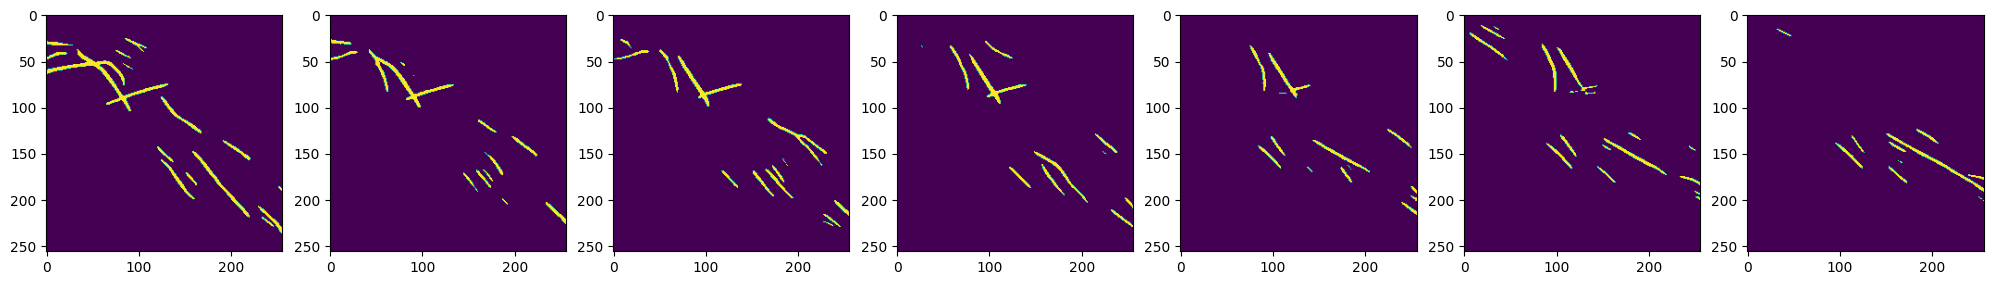

In [18]:
no = 16
id = os.listdir(CFG.new_label_path)[no*7].split("_")[0]
fig, ax = plt.subplots(1, 7, figsize=(25, 10))
for i, time in enumerate([0, 1, 2, 3, 5, 6, 7]):
    npy = np.load(f"{CFG.new_label_path}/{id}_{time}.npy")
    ax[i].imshow(npy)

In [25]:
label_df = train_df[train_df["fold"] == -1]

dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[0]
model, dice_score, thresh = load_model(model_path)
model.eval()
print(f"{dice_score = :.4f}")
print(f"{thresh = }")

pseudo_inference(dataloader_label, model, thresh, "/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/valid")

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


 77%|███████▋  | 494/642 [18:21<05:30,  2.23s/it]


KeyboardInterrupt: 